In [1]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,wH:float,wL:float,p:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        self.wH = wH
        self.wL = wL
        self.p = p

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド

In [2]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 1.0
    rent = 1.025**30 - 1.0
    # added
    wH = 1.0
    wL = 0.1
    p = 0.5

    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = np.linspace(w_min,w_max,nw)

    return Models(β, γ, rent, wH, wL, p, nw, w_max, w_min, grid_w)

In [3]:
def CRRA(cons,γ):
    if γ != 1.0:
        return cons**(1.0 - γ) / (1.0 - γ)
    else:
        return np.log(cons)

In [4]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
# import time # 計測時間をはかるためのパッケージ

In [5]:
def obj_two_period_unc(a,w_val,params):
    """
    所得wを所与として、2期間モデルの生涯効用を返す関数
    @author Tokuma Suzuki(Julia ver)
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 所得水準
    `m::Models`: パラメータを含む構造体(βとかγ：カリブレーションの場所で設定済み)

    # アウトプット 
    生涯効用:
    """
    # 1期目の効用
    c1 = w_val - a
    if  c1 > 0.0:
        util_y = CRRA(c1, params.γ)
    else:
        util_y = -1000000.0 #負の消費に対するペナルティ
    
    # 2期目の割引効用
    c2H = (1.0+params.rent)*a + params.wH
    c2L = (1.0+params.rent)*a + params.wL
    if (c2L > 0.0):
        util_o = params.β*params.p*CRRA(c2H, params.γ) + params.β*(1-params.p)*CRRA(c2L, params.γ)

In [6]:
def obj_two_period_unc(a,w_val,params):
    """
    所得wを所与として、2期間モデルの生涯効用を返す関数
    @author Tokuma Suzuki(Julia ver)
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 所得水準
    `m::Models`: パラメータを含む構造体(βとかγ：カリブレーションの場所で設定済み)

    # アウトプット 
    生涯効用:
    """
    # 1期目の効用
    c1 = w_val - a
    if  c1 > 0.0:
        util_y = CRRA(c1, params.γ)
    else:
        util_y = -1000000.0 #負の消費に対するペナルティ
    
    # 2期目の割引効用
    c2H = (1.0+params.rent)*a + params.wH
    c2L = (1.0+params.rent)*a + params.wL
    if (c2L > 0.0):
        util_o = params.β*params.p*CRRA(c2H, params.γ) + params.β*(1-params.p)*CRRA(c2L, params.γ)
    else:
        util_o = -1000000.0

    # optimizeが最小値を探すので、マイナスをかけることで最適な値を求める。
    return  -1.0*(util_y + util_o)

In [7]:
# 事前に設定しておいたパラメータをparamsという一つの変数にまとめる：struct
params = Calibration()

# 空の変数を用意
a_gs = np.zeros(params.nw)
from scipy.optimize import Bounds

# 各wについて目的関数を最大にするような貯蓄水準aを求める
for (w_ind,w_val) in enumerate(params.grid_w):
    
    # 関数obj_two_periodを再定義
    # "aのみをargument"とする関数を作る：optimizeの中に入れる関数はパラメータを与えたもとでの関数である必要あり
    obj_two_period1 = lambda a: obj_two_period_unc(a,w_val,params)

    # ブレント法(Brents' method)により計算
    # 使い方：aの最適値を探す範囲を指定→[w_val*0.01, w_val*2.0]
    # この範囲内で関数を最小(最大)にするaを見つけ出すアルゴリズム
    
    # res = optimize.fminbound(obj_two_period1,w_val*0.01,w_val*2.0)
    res = optimize.fminbound(obj_two_period1,-0.1,w_val*2.0)
    a_gs[w_ind] = res

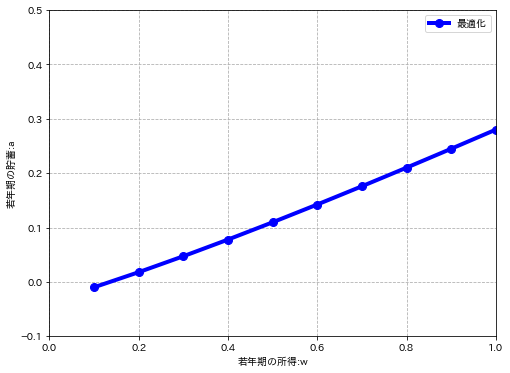

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,a_gs,c="b",marker="o",lw=4,ms=8,label="最適化")
# ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.0),ylim=(-0.1,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()